In [20]:
import os
import platform 
import gc

import re
import numpy as np
import pandas as pd

pd.options.display.max_columns = None
pd.options.display.max_rows = None


import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

import lightgbm as lgb

import warnings 
warnings.filterwarnings('ignore')

In [21]:
X = pd.read_csv('./input/train_data.csv')
X_test = pd.read_csv('./input/test_data.csv')
test_id = X_test['id']

In [22]:
y = X['salary']
X = X.drop(['salary', 'id'], axis=1)
X_test = X_test.drop(['id'], axis=1)

In [23]:
X.dtypes

position            int64
age                 int64
area               object
sex                 int64
partner             int64
num_child           int64
education           int64
service_length      int64
study_time        float64
commute           float64
overtime          float64
dtype: object

# Feature Engineering

## salaryと相関が強い
1. position
- age
- service_length
- commute

In [24]:
def create_feature(df):
    '''
    #歳による役職
    df['MA'] = df['age'].apply(lambda x: 1 if (x >= 26) else 0)
    df['GM'] =  df['age'].apply(lambda x: 1 if (x >= 31) else 0)
    df['not_noname'] = df['age'].apply(lambda x: 1 if (x <= 31) else 0)
    '''
    
    '''
    #歳による役職
    df['position_age'] = 0
    df['position_age'][(df['age'] >=18) & (df['age'] <=25)] = 0
    df['position_age'][(df['age'] >=26) & (df['age'] <=31)] = 1
    df['position_age'][(df['age'] >=32) & (df['age'] <=36)] = 2
    df['position_age'][(df['age'] >=37)& (df['age'] <=58)] = 3
    df['position_age'][(df['age'] >=59)] = 4
    '''
    
    #家族の数(自分を含む)
    df['family'] = 1 + df['partner'] + df['num_child']
    
    #総通勤時間
    df['total_commute'] = df['service_length'] * (((df['commute']*2) * 25) * 12)
    
    #月当たり：会社以外の時間
    df['time_for_company'] = df['overtime'] + ((df['commute']*2) * 25)
    
    #入社した歳
    df['age_enter'] = df['age'] - df['service_length']
    
    #===卒業した歳===
    age_graduate = {0:18, 1:20, 2:22, 3:24, 4:27}
    df['age_graduate'] = df['education'].map(age_graduate)
    
    #新卒?中途?
    df['fresh_mid'] = df['age_enter'] - df['age_graduate']
    
    #月当たり：自由な時間
    #土日休みとする
    df['free_time'] = 24*31 - ( 9*25 + (df['commute']*2)*25 + df['overtime'])
    
    #自分だけの時間
    df['aman_free_time'] = df['free_time'] / df['family']
    
    #勉強に費やしている時間の割合
    df['study_per_freetime'] = df['study_time'] / df['aman_free_time']
    
    
    return df

In [25]:
X = create_feature(X)
X_test = create_feature(X_test)

## Labeling

In [26]:
def labeling(X, X_test, y):
    col_category = []
    for i in X.columns:
        if X[i].dtype == 'object':
            
            # ======== ラベルエンコーディング ==========
            le = LabelEncoder()
            X[f'{i}_label'] = le.fit_transform(X[i])
            X_test[f'{i}_label'] = le.transform(X_test[i])
            
            col_category.append(f'{i}_label')
            
            
            # ========= ランキング ==============
            maps = pd.concat([X, np.exp(y)], axis=1).groupby(i)['salary'].mean().sort_values(ascending=False).index
            maps = pd.DataFrame({i: maps, 'rank': np.linspace(0, maps.shape[0]-1, maps.shape[0])})
            maps = dict(maps.to_dict(orient='split')['data'])
            X[f'{i}_rank'] = X[i].map(maps)
            X_test[f'{i}_rank'] = X_test[i].map(maps)
            
            col_category.append(f'{i}_rank')
            
            
            # ===== targeting =======
            data_tmp = pd.DataFrame({i:X[i], 'target':y})
            target_mean = data_tmp.groupby(i)['target'].mean()
            
            X_test[f'{i}_target'] = X_test[i].map(target_mean)
            #X_test[f'{c}_target_log'] = np.log(X_test[c].map(target_mean))
            
            tmp = np.repeat(np.nan, X.shape[0])
            
            kf = KFold(n_splits=4, shuffle=True, random_state=72)
            
            for idx_1, idx_2 in kf.split(X):
                target_mean = data_tmp.iloc[idx_1].groupby(i)['target'].mean()
                tmp[idx_2] = X[i].iloc[idx_2].map(target_mean)
                X[f'{i}_target'] = tmp
                #X[f'{c}_target_log'] = np.log(tmp)
            
            col_category.append(f'{i}_target')
            #new_col_category.append(f'{c}_target_log')
            
            # ===== 元のラベルの削除 =====
            X = X.drop(i, axis=1)
            X_test = X_test.drop(i, axis=1)
            
    return X, X_test, col_category

In [27]:
X, X_test, col_category = labeling(X, X_test, y)

In [28]:
print('X.shape', X.shape,
      '\nX_test.shape', X_test.shape,
     )

X.shape (21000, 22) 
X_test.shape (9000, 22)


In [29]:
X.head()

,position,age,sex,partner,num_child,education,service_length,study_time,commute,overtime,family,total_commute,time_for_company,age_enter,age_graduate,fresh_mid,free_time,aman_free_time,study_per_freetime,area_label,area_rank,area_target
0,1,44,2,1,2,1,24,2.0,1.6,9.2,4,23040.0,89.2,20,20,0,429.8,107.45,0.018613,24,36.0,394.344582
1,2,31,1,0,0,0,13,9.0,0.7,12.4,1,5460.0,47.4,18,18,0,471.6,471.60,0.019084,10,11.0,369.951268
2,2,36,1,0,0,2,14,4.0,0.4,16.9,1,3360.0,36.9,22,22,0,482.1,482.10,0.008297,14,8.0,357.888184
3,0,22,2,0,0,0,4,3.0,0.4,6.1,1,960.0,26.1,18,18,0,492.9,492.90,0.006086,26,44.0,406.042014
4,0,25,2,0,0,1,5,3.0,0.2,4.9,1,600.0,14.9,20,20,0,504.1,504.10,0.005951,46,0.0,351.506991


In [30]:
y = np.log(y)

In [31]:
params = {
    'objective': 'fair',
    'metric': 'fair',
    'learning_rate': 0.01,
    'max_depth': -1,
    'num_leaves': 255,
    'max_bin': 255,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'nthread': -1,
    'bagging_freq': 1,
    'verbose': -1,
    'seed': 1,
}

In [32]:
def lightgbms(X, X_test, y, params, random=0):
    
    NFOLDS = 5
    
    folds = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=random)

    preds = pd.DataFrame()
    train_preds = pd.DataFrame()

    columns = X.columns
    splits = folds.split(X, X['area_label'])

    y_preds = np.zeros(X_test.shape[0])
    y_oof = np.zeros(X.shape[0])

    score = 0
    scores = []

    feature_importances = pd.DataFrame()
    feature_importances['feature'] = columns

    for fold_n, (train_index, val_index) in enumerate(splits):
        # split train, Valid
        X_train, X_val = X[columns].iloc[train_index], X[columns].iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        '''
        LightGBM
        '''
        dtrain = lgb.Dataset(X_train, y_train)
        dval = lgb.Dataset(X_val, y_val)

        clf = lgb.train(params,
                        dtrain,
                        5000,
                        valid_sets=[dtrain, dval],
                        verbose_eval=1000,
                        categorical_feature=col_category,
                        early_stopping_rounds=500)
        
        
        feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
        
        '''
        LightGBM
        '''
        # stack
        y_pred_val = clf.predict(X_val)
        y_oof[val_index] = y_pred_val
    
            
        print(f"Fold {fold_n + 1} | rmse: {mean_absolute_error(np.exp(y_val),np.exp( y_pred_val))}")
        
        score += mean_absolute_error(np.exp(y_val),np.exp( y_pred_val)) / NFOLDS
        scores.append(mean_absolute_error(np.exp(y_val),np.exp( y_pred_val)))

        y_preds += clf.predict(X_test) / NFOLDS

        train_preds[f"Fold {fold_n + 1}"] = clf.predict(X)

        preds[f"Fold {fold_n + 1}"] = clf.predict(X_test)

        del X_train, X_val, y_train, y_val
        gc.collect()
    print(f"\nMean RSME = {score}")

    return y_oof, y_preds, scores, feature_importances

In [33]:
%%time
## === Seed ===
_, y_preds1, _, feature_importances = lightgbms(X, X_test, y, params, 1)
_, y_preds2, _, _ = lightgbms(X, X_test, y, params, 2)
_, y_preds3, _, _ = lightgbms(X, X_test, y, params, 3)
_, y_preds4, _, _ = lightgbms(X, X_test, y, params, 4)
_, y_preds5, _, _ = lightgbms(X, X_test, y, params, 5)

Training until validation scores don't improve for 500 rounds.
[1000]	training's fair: 0.000813796	valid_1's fair: 0.00382589
Early stopping, best iteration is:
[625]	training's fair: 0.00135504	valid_1's fair: 0.00379055
Fold 1 | rmse: 23.393581973576744
Training until validation scores don't improve for 500 rounds.
[1000]	training's fair: 0.000822639	valid_1's fair: 0.00369278
Early stopping, best iteration is:
[773]	training's fair: 0.00111032	valid_1's fair: 0.00368354
Fold 2 | rmse: 23.38119589171871
Training until validation scores don't improve for 500 rounds.
[1000]	training's fair: 0.000828699	valid_1's fair: 0.00376241
Early stopping, best iteration is:
[704]	training's fair: 0.00122818	valid_1's fair: 0.00375323
Fold 3 | rmse: 23.436618474997378
Training until validation scores don't improve for 500 rounds.
[1000]	training's fair: 0.000819052	valid_1's fair: 0.0036621
Early stopping, best iteration is:
[616]	training's fair: 0.00138219	valid_1's fair: 0.00362567
Fold 4 | rms

In [34]:
pred_list = [y_preds1,
             y_preds2,
             y_preds3,
             y_preds4,
             y_preds5]
pred = np.zeros(X_test.shape[0])
for i in pred_list:
    pred += np.exp(i).astype(int) / 5
    
pred = pred.astype(int)

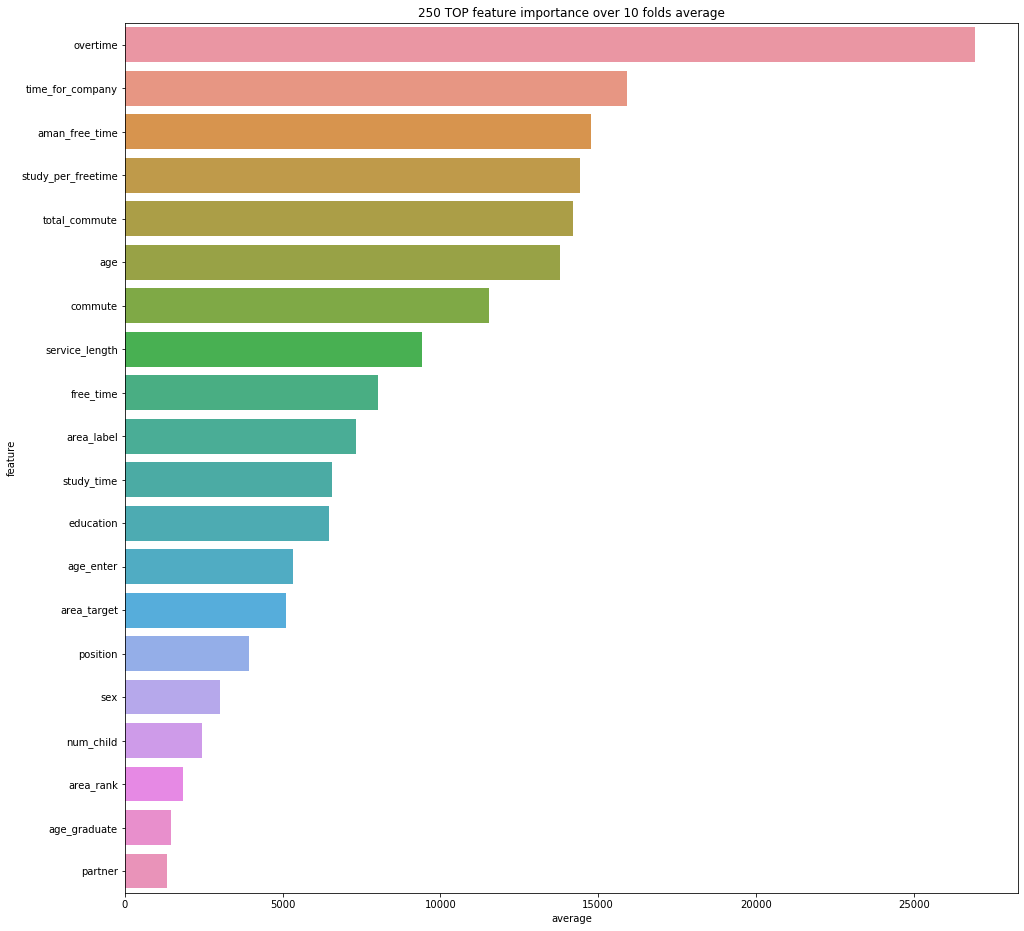

In [35]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(5)]].mean(axis=1)

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(20), x='average', y='feature');
plt.title('250 TOP feature importance over {} folds average'.format(10))
#plt.savefig('TOP250_feature_importance.png')
plt.show()

In [36]:
sub = pd.DataFrame({'id': test_id, 'y': pred})

In [37]:
sub.head()

,id,y
0,0,513
1,1,270
2,2,207
3,3,156
4,4,288


In [38]:
sub.to_csv('sub_lgb_fifth.csv', index=None)